# Downloading the Data


In [ ]:
!gdown https://drive.google.com/u/0/uc?id=1CIv7wheOC0TgQArukUDWjPd3tJqckmRp

Downloading...
From: https://drive.google.com/u/0/uc?id=1CIv7wheOC0TgQArukUDWjPd3tJqckmRp
To: /content/Post-hurricane.zip
66.1MB [00:00, 81.1MB/s]


In [ ]:
!pip -qq install tf_keras_vis

In [ ]:
!unzip Post-hurricane.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_another/no_damage/-95.62751800000001_29.857785999999997.jpeg  
  inflating: train_another/no_damage/-95.62751999999999_29.860796999999998.jpeg  
  inflating: train_another/no_damage/-95.627523_29.770004999999998.jpeg  
  inflating: train_another/no_damage/-95.62753000000001_29.863289.jpeg  
  inflating: train_another/no_damage/-95.627539_29.827047999999998.jpeg  
  inflating: train_another/no_damage/-95.627543_29.860021000000003.jpeg  
  inflating: train_another/no_damage/-95.627563_29.8628.jpeg  
  inflating: train_another/no_damage/-95.627579_29.864051.jpeg  
  inflating: train_another/no_damage/-95.627595_29.776602.jpeg  
  inflating: train_another/no_damage/-95.62759799999999_29.777317.jpeg  
  inflating: train_another/no_damage/-95.62760300000001_29.778018.jpeg  
  inflating: train_another/no_damage/-95.62760899999999_29.85947.jpeg  
  inflating: train_another/no_damage/-95.627638_29.769610999999998.jpeg  
  inf

#Importing the neccessary libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import skimage.io
import os
import random
random.seed(42)
tf.random.set_seed(42)
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow.keras as K
from sklearn.utils import shuffle
%load_ext tensorboard
import datetime
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb
from sklearn.cluster import KMeans
from tf_keras_vis.gradcam import Gradcam
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report, accuracy_score

#Loading and sneak-peeking at few images


In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = skimage.io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
X_train_damage = load_images_from_folder('./train_another/damage')
X_train_no_damage = load_images_from_folder('./train_another/no_damage')
X_val_damage = load_images_from_folder('./validation_another/damage')
X_val_no_damage = load_images_from_folder('./validation_another/no_damage')

In [ ]:
y_damage =  np.ones(5000)
y_no_damage =  np.zeros(5000)

X_train = np.concatenate((X_train_damage, X_train_no_damage))# making training data
y_train = np.concatenate((y_damage, y_no_damage))

X_train, y_train = shuffle(X_train, y_train, random_state= 42)

In [ ]:
y_damage_val =  np.ones(1000)
y_no_damage_val =  np.zeros(1000)

X_train_val = np.concatenate((X_val_damage, X_val_no_damage))# making validation data
y_train_val = np.concatenate((y_damage_val, y_no_damage_val))

X_val, y_val = shuffle(X_train_val, y_train_val, random_state= 42)

In [ ]:
map_dict = {1:'damage',0:'no_damage'}

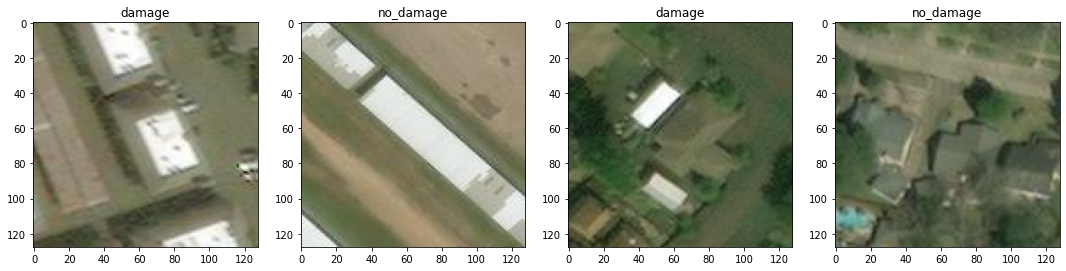

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(15,15))

k=4
for i in range(0,4):
  img = X_train[k].astype('uint8')
  axes[i].imshow(img)
  axes[i].set_title(map_dict[y_train[k]])
  k+=1
fig.tight_layout()

#Preprocessing starts!

In [ ]:
# sharping training and validation images
X_train_final = []
for i in range(X_train.shape[0]):
  img = X_train[i]
  image_pil = Image.fromarray(img)
  enhancer = ImageEnhance.Sharpness(image_pil)
  factor = 3.0
  im_s_1 = enhancer.enhance(factor)
  X_train_final.append(np.array(im_s_1))
X_train_final = np.array(X_train_final)

X_val_final = []
for i in range(X_val.shape[0]):
  img = X_val[i]
  image_pil = Image.fromarray(img)
  enhancer = ImageEnhance.Sharpness(image_pil)
  factor = 3
  im_s_1 = enhancer.enhance(factor)
  X_val_final.append(np.array(im_s_1))
X_val_final = np.array(X_val_final)

## Showing the preprocessed images

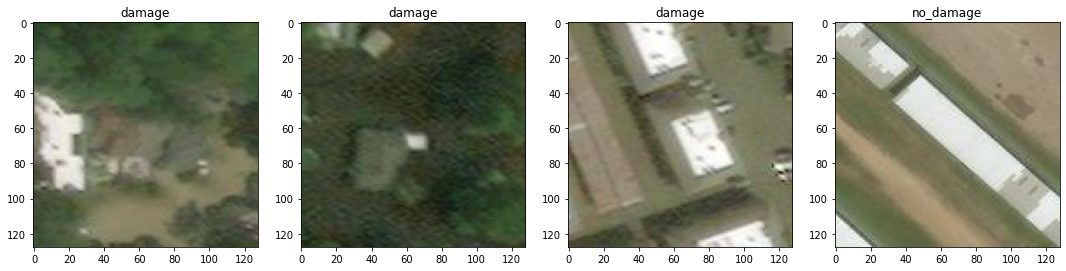

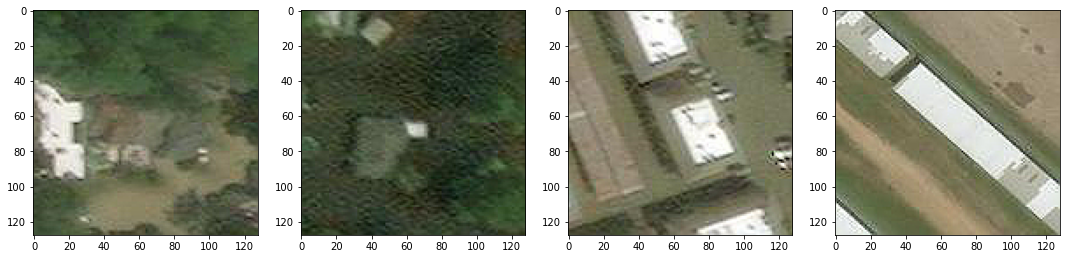

In [ ]:
fig, axes = plt.subplots(1,4,figsize=(15,15))

k=2
for i in range(0,4):
  img = X_train[k].astype('uint8')
  axes[i].imshow(img)
  axes[i].set_title(map_dict[y_train[k]])
  k+=1
fig.tight_layout()

k=2
fig, axes = plt.subplots(1,4,figsize=(15,15))

for i in range(0,4):
  img_sharpened = X_train_final[k].astype('uint8')
  axes[i].imshow(img_sharpened)
  k+=1
fig.tight_layout()

#Data Augmentation & Building the model

##Data Augmentation

In [ ]:
train_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20,vertical_flip=True,
                               zoom_range=0.2, shear_range=0.1,
                               height_shift_range=0.05, width_shift_range=0.05)
val_gen = ImageDataGenerator()
train_images = train_gen.flow(X_train_final,y_train,shuffle=True, batch_size=128)
validation_images = val_gen.flow(X_val_final, y_val,shuffle=True, batch_size=128)

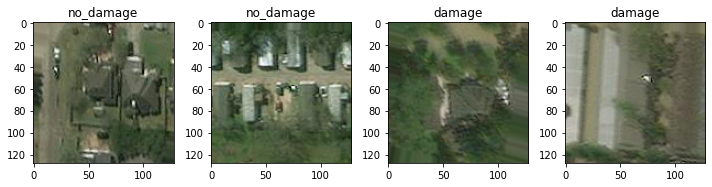

In [ ]:
# showing some augmented images
imgs_val = next(train_images)
imgs = imgs_val[0]
val = imgs_val[1]
fig, axes = plt.subplots(1,4, figsize=(10,10))
for i in range(4):
  axes[i].imshow(imgs[i].astype('uint8'))
  axes[i].set_title(map_dict[val[i]])
fig.tight_layout()

In [ ]:
train_gen = ImageDataGenerator(horizontal_flip=True, rotation_range=20,vertical_flip=True,
                               zoom_range=0.2, shear_range=0.1,preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
                               height_shift_range=0.05, width_shift_range=0.05)
val_gen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
train_images = train_gen.flow(X_train_final,y_train,shuffle=True, batch_size=128)
validation_images = val_gen.flow(X_val_final, y_val,shuffle=True, batch_size=128)

##Callback

In [ ]:
es = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1, restore_best_weights=True, monitor='val_loss')
es1 = tf.keras.callbacks.EarlyStopping(patience=2, verbose=1, restore_best_weights=True, monitor='val_loss')

## Building the model

In [ ]:
from keras.layers import Lambda, Input

model_res = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in model_res.layers:
    layer.trainable=False


x = K.layers.GlobalAveragePooling2D()(model_res.output)
x = K.layers.Dense(128, activation='relu')(x)
x = K.layers.BatchNormalization()(x)
x = K.layers.Dropout(rate=0.3)(x)
output = K.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=model_res.input, outputs=output)

model.summary()
model.compile(optimizer=K.optimizers.Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
#training only the dense layers
history=model.fit(train_images,validation_data= validation_images,steps_per_epoch= (10000//128),epochs=5,
                                                validation_steps=(2000//128), callbacks=[es])

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
for layer in model.layers[-12:]:#training last 12 layers of the model
    layer.trainable=True
model.compile(optimizer=K.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history1=model.fit(train_images,validation_data= validation_images,steps_per_epoch= (10000//128),epochs=8,validation_steps=(2000//128), callbacks=[es1])

Epoch 1/8
78/78 [==============================] - 42s 532ms/step - loss: 0.0984 - accuracy: 0.9610 - val_loss: 0.0967 - val_accuracy: 0.9599
Epoch 2/8
78/78 [==============================] - 41s 524ms/step - loss: 0.0917 - accuracy: 0.9634 - val_loss: 0.0789 - val_accuracy: 0.9688
Epoch 3/8
78/78 [==============================] - 41s 528ms/step - loss: 0.0755 - accuracy: 0.9713 - val_loss: 0.0851 - val_accuracy: 0.9682
Epoch 4/8
78/78 [==============================] - 41s 525ms/step - loss: 0.0656 - accuracy: 0.9742 - val_loss: 0.0763 - val_accuracy: 0.9714
Epoch 5/8
78/78 [==============================] - 40s 518ms/step - loss: 0.0611 - accuracy: 0.9759 - val_loss: 0.0985 - val_accuracy: 0.9641
Epoch 6/8
78/78 [==============================] - 41s 523ms/step - loss: 0.0622 - accuracy: 0.9764 - val_loss: 0.0783 - val_accuracy: 0.9719
Epoch 00006: early stopping


##Visualizing the trained model

In [ ]:
pred = model.predict(tf.keras.applications.resnet50.preprocess_input(X_val_final))
pred = pred.ravel()
pred = (pred>0.5).astype('int')
diff_pred = np.abs(pred-y_val)
correct_classified = np.where(diff_pred==0)
incorrect_classified = np.where(diff_pred==1)

### Visualizing using Gradcam

In [ ]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m
def loss(output):
    return (output)
# Create Gradcam object
def grad(index):
  gradcam = Gradcam(model,model_modifier=model_modifier,clone=False)

  cam = gradcam(loss,np.expand_dims(tf.keras.applications.resnet50.preprocess_input(X_val[correct_classified[index]]),axis=0),penultimate_layer=-1)
  cam = normalize(cam)
  return cam

Text(0.5, 1.0, 'GradCAM')

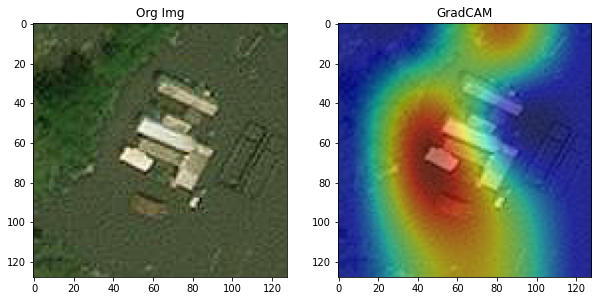

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,10))

axes[0].imshow(X_val_final[correct_classified[698]])
axes[0].set_title("Org Img")
heatmap1 = np.uint8(cm.jet(grad(698)[0])[..., :3] * 255)
axes[1].imshow(X_val_final[correct_classified[698]])
axes[1].imshow(heatmap1, cmap='jet', alpha=0.5)
axes[1].set_title("GradCAM")

Text(0.5, 1.0, 'GradCAM')

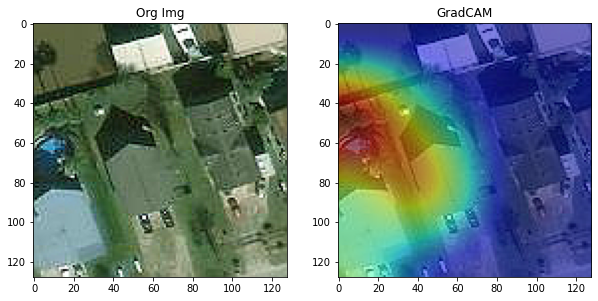

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,10))

axes[0].imshow(X_val_final[correct_classified[198]])
axes[0].set_title("Org Img")
heatmap1 = np.uint8(cm.jet(grad(198)[0])[..., :3] * 255)
axes[1].imshow(X_val_final[correct_classified[198]])
axes[1].imshow(heatmap1, cmap='jet', alpha=0.5)
axes[1].set_title("GradCAM")

Text(0.5, 1.0, 'GradCAM')

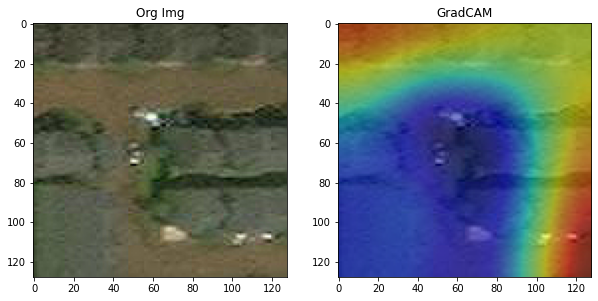

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,10))

axes[0].imshow(X_val_final[correct_classified[98]])
axes[0].set_title("Org Img")
heatmap1 = np.uint8(cm.jet(grad(98)[0])[..., :3] * 255)
axes[1].imshow(X_val_final[correct_classified[98]])
axes[1].imshow(heatmap1, cmap='jet', alpha=0.5)
axes[1].set_title("GradCAM")

Text(0.5, 1.0, 'GradCAM')

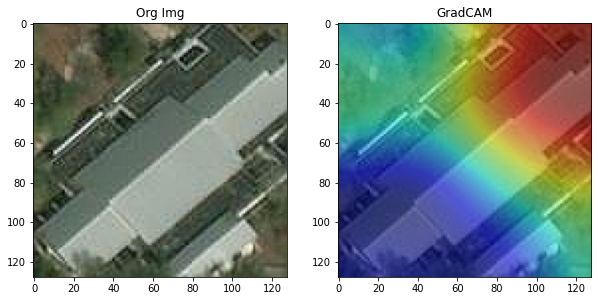

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(10,10))

axes[0].imshow(X_val_final[correct_classified[-1]])
axes[0].set_title("Org Img")
heatmap1 = np.uint8(cm.jet(grad(-1)[0])[..., :3] * 255)
axes[1].imshow(X_val_final[correct_classified[-1]])
axes[1].imshow(heatmap1, cmap='jet', alpha=0.5)
axes[1].set_title("GradCAM")

#Evaluating the model

In [ ]:
X_test =  []
X_test.extend(load_images_from_folder('/content/test/damage'))
X_test.extend(load_images_from_folder('/content/test/no_damage'))
X_test = np.array(X_test)
X_test.shape

(2000, 128, 128, 3)

In [ ]:
y_test = []
y_test.extend(np.ones(1000))
y_test.extend(np.zeros(1000))
y_test = np.array(y_test)

In [ ]:
# preprocessing the balanced test set
X_test_final = []
for i in range(X_test.shape[0]):
  img = X_test[i]
  image_pil = Image.fromarray(img)
  enhancer = ImageEnhance.Sharpness(image_pil)
  factor = 3
  im_s_1 = enhancer.enhance(factor)
  X_test_final.append(np.array(im_s_1))
X_test_final = np.array(X_test_final)

In [ ]:
pred = model.predict(tf.keras.applications.resnet50.preprocess_input(X_test_final))
pred = pred.ravel()
pred = (pred>0.5).astype('int')

## Classification report for balanced test data

In [ ]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      1000
         1.0       0.98      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [ ]:
X_test =  []
X_test.extend(load_images_from_folder('/content/test_another/damage'))
X_test.extend(load_images_from_folder('/content/test_another/no_damage'))
X_test = np.array(X_test)
X_test.shape

(9000, 128, 128, 3)

In [ ]:
y_test = []
y_test.extend(np.ones(8000))
y_test.extend(np.zeros(1000))
y_test = np.array(y_test)

In [ ]:
# preprocessing the unbalanced test set
X_test_final = []
for i in range(X_test.shape[0]):
  img = X_test[i]
  image_pil = Image.fromarray(img)
  enhancer = ImageEnhance.Sharpness(image_pil)
  factor = 3
  im_s_1 = enhancer.enhance(factor)
  X_test_final.append(np.array(im_s_1))
X_test_final = np.array(X_test_final)

In [ ]:
pred = model.predict(tf.keras.applications.resnet50.preprocess_input(X_test_final))
pred = pred.ravel()
pred = (pred>0.5).astype('int')

## Classification report for unbalanced test data

In [ ]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.82      0.96      0.88      1000
         1.0       1.00      0.97      0.98      8000

    accuracy                           0.97      9000
   macro avg       0.91      0.97      0.93      9000
weighted avg       0.98      0.97      0.97      9000

